In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [42]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [124]:
# Inspect table to get column names and date types from Measurement table

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [125]:
# Inspect table to get column names and date types from Station table

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [165]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

most_recent = dt.datetime(2017, 8, 23)

one_year_prior = most_recent - relativedelta(years=1)

one_year_prior

# Perform a query to retrieve the data and precipitation scores, over the past year, sorted by date

dates_prcp = session.query(Measurement.date, Measurement.prcp, Measurement.station).\
            filter(Measurement.date >= one_year_prior).\
            order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame

df_dates_prcp = pd.DataFrame(dates_prcp, columns = ['date', 'precipitation', 'station'])

df_dates_prcp.head()


,date,precipitation,station
0,2017-08-23,0.00,USC00519397
1,2017-08-23,0.00,USC00514830
2,2017-08-23,0.08,USC00519523
3,2017-08-23,0.45,USC00516128
4,2017-08-22,0.00,USC00519397


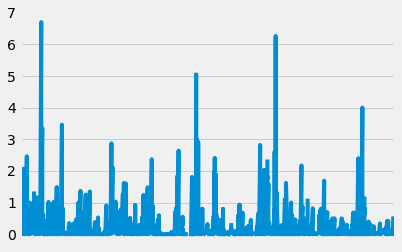

In [139]:
# Use Pandas Plotting with Matplotlib to plot the data

from matplotlib.dates import DateFormatter

data = df_dates_prcp

fig1, ax1 = plt.subplots()
ax1.plot('date', 'precipitation', data = data)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

date_min = data['date'][len(data['date'])-1]
date_max = data['date'][0]
ax1.set_xlim(date_min, date_max)

plt.show()


In [138]:
# Use Pandas to calculate the summary statistics for the precipitation data

df_dates_prcp['precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [176]:
# Design a query to show how many stations are available in this dataset

all_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [178]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.



'USC00519281'

In [179]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = all_stations[0][0]

sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

most_active_summary = session.query(*sel).\
                    filter(Measurement.station == most_active).all()

df_most_active_summary = pd.DataFrame(most_active_summary,columns=['station', 'min_temp', 'max_temp', 'avg_temp'])

df_most_active_summary


,station,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


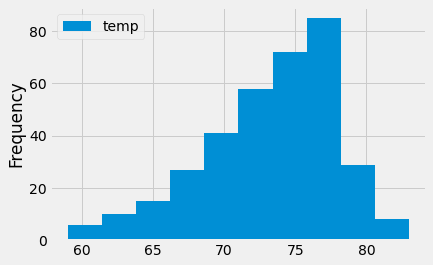

In [188]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_temps = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
            filter(Measurement.date >= one_year_prior).filter(Measurement.station == most_active).\
            order_by(Measurement.date.desc()).all()

df_most_active_temps = pd.DataFrame(most_active_temps, columns = ['date', 'temp', 'station'])

df_most_active_temps = df_most_active_temps.drop(columns=['station'])

df_most_active_temps.plot.hist(df_most_active_temps['temp'])
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
